# Выбор локации для скважины

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Для этого предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:

В избранном регионе ищем месторождения, для каждого определяем значения признаков;

Строим модель и оценивем объём запасов;

Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;

Прибыль равна суммарной прибыли отобранных месторождений.

##### Описание данных
-	id — уникальный идентификатор скважины;
-	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
-	product — объём запасов в скважине (тыс. баррелей).

##### Данные геологоразведки трёх регионов находятся в файлах:
-	/datasets/geo_data_0.csv
-	/datasets/geo_data_1.csv
-	/datasets/geo_data_2.csv

##### Условия задачи:
-	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
-	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
-	Бюджет на разработку скважин в регионе — 10 млрд рублей.
-	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
-	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display
from numpy.random import RandomState
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data_0 = pd.read_csv('/datasets/geo_data_0.csv')
# data_1 = pd.read_csv('/datasets/geo_data_1.csv')
# data_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_0 = pd.read_csv('/Users/Mikalai/Documents/Data Science/Проект Машинное обучение в бизнесе/geo_data_0.csv')
data_1 = pd.read_csv('/Users/Mikalai/Documents/Data Science/Проект Машинное обучение в бизнесе/geo_data_1.csv')
data_2 = pd.read_csv('/Users/Mikalai/Documents/Data Science/Проект Машинное обучение в бизнесе/geo_data_2.csv')

Посмотрим на первые 10 строк каждой таблицы

In [3]:
print('\n\nДанные геологоразведки Регион_0\n')
display(data_0.head(10))
print('\n\nДанные геологоразведки Регион_1\n')
display(data_1.head(10))
print('\n\nДанные геологоразведки Регион_2\n')
display(data_2.head(10))



Данные геологоразведки Регион_0



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945




Данные геологоразведки Регион_1



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408




Данные геологоразведки Регион_2



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Просмотрим информацию о данных

In [4]:
print('\n\nИнформация о таблице Регион_0\n')
display(data_0.info())
print('\n\nИнформация о таблице Регион_1\n')
display(data_1.info())
print('\n\nИнформация о таблице Регион_2\n')
display(data_2.info())



Информация о таблице Регион_0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None



Информация о таблице Регион_1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None



Информация о таблице Регион_2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Посмотрим описание данных

In [5]:
print('\n\nОписание данных в таблице Регион_0\n')
display(data_0.describe())
print('\n\nОписание данных в таблице Регион_1\n')
display(data_1.describe())
print('\n\nОписание данных в таблице Регион_2\n')
display(data_2.describe())



Описание данных в таблице Регион_0



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347




Описание данных в таблице Регион_1



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408




Описание данных в таблице Регион_2



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Проверим данные на дубликаты

In [6]:
print("Строк с дубликатами Регион_0:", data_0.duplicated().sum())
print("Строк с дубликатами Регион_1:", data_1.duplicated().sum())
print("Строк с дубликатами Регион_2:", data_2.duplicated().sum())

Строк с дубликатами Регион_0: 0
Строк с дубликатами Регион_1: 0
Строк с дубликатами Регион_2: 0


Посмотрим количество уникальных значений в данных

In [7]:
print('К-во уникальных значений в данных Регион_0:')
display(data_0.nunique())
print('К-во уникальных значений в данных Регион_1:')
display(data_1.nunique())
print('К-во уникальных значений в данных Регион_1:')
display(data_1.nunique())

К-во уникальных значений в данных Регион_0:


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

К-во уникальных значений в данных Регион_1:


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

К-во уникальных значений в данных Регион_1:


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

В данных присутствуют повторяющиеся id, что странно, т.к. каждый id должен отображать уникальное месторождение.

Найдем повторяющиеся id

In [8]:
print('Уникальных id скважин Регион_0:')
display(data_0['id'].value_counts().head(10))
print('Уникальных id скважин Регион_1:')
display(data_1['id'].value_counts().head(4))
print('Уникальных id скважин Регион_2:')
display(data_2['id'].value_counts().head(4))

Уникальных id скважин Регион_0:


fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
A5aEY    2
bsk9y    2
TtcGQ    2
HZww2    2
bxg6G    2
Name: id, dtype: int64

Уникальных id скважин Регион_1:


wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
Name: id, dtype: int64

Уникальных id скважин Регион_2:


VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
Name: id, dtype: int64

Посмотрим выборочно на строки с дублирующимися id

In [9]:
display(data_0.loc[data_0['id'] == '74z30'])
display(data_0.loc[data_0['id'] == 'TtcGQ'])
display(data_0.loc[data_0['id'] == 'fiKDv'])

,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


In [10]:
display(data_1.loc[data_1['id'] == 'wt4Uk'])
display(data_1.loc[data_1['id'] == 'bfPNe'])

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


,id,f0,f1,f2,product
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


In [11]:
display(data_2.loc[data_2['id'] == 'KUPhW'])
display(data_2.loc[data_2['id'] == 'xCHr8'])

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Остальные данные не дублируются. Вероятно произошла ошибка при записи id. Удалять строки с дублирующимися id не буду. 

Данные успешно загружены и проверены на соответствие описанию.

Даннные из файлов в трёх регионах имеют по 100 тыс объектов, по 5 признаков. Пропусков нет. Дублируется незначительное количество id. Вероятно произошла ошибка при записи id. Остальные данные с одинаковыми id не дублируются, поэтому не удалял строки с дублирующимися id. 

Предварительной обработки данных не требуется.

Удалим столбец id, так как для обучения моделей он нам не понадобится.

In [12]:
data_0 = data_0.drop('id', axis=1)
display(data_0.head())

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [13]:
data_1 = data_1.drop('id', axis=1)
display(data_1.head())

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [14]:
data_2 = data_2.drop('id', axis=1)
display(data_2.head())

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Посмотрим корреляцию данных 

In [15]:
print("\nКорреляция данных Регион_0")
display(data_0.corr())


Корреляция данных Регион_0


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Text(0.5, 1.0, 'Корреляция между признаками Регион_0')

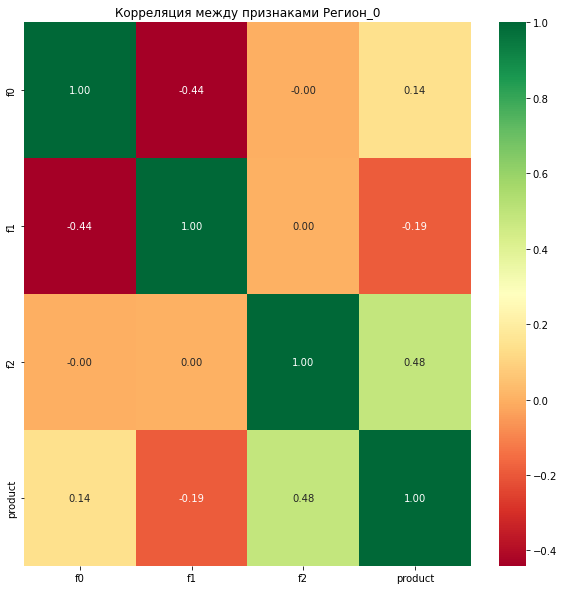

In [16]:
Corr_0=data_0.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Corr_0, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками Регион_0')

In [17]:
print()
print("\nКорреляция данных Регион_1")
display(data_1.corr())



Корреляция данных Регион_1


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Text(0.5, 1.0, 'Корреляция между признаками Регион_1')

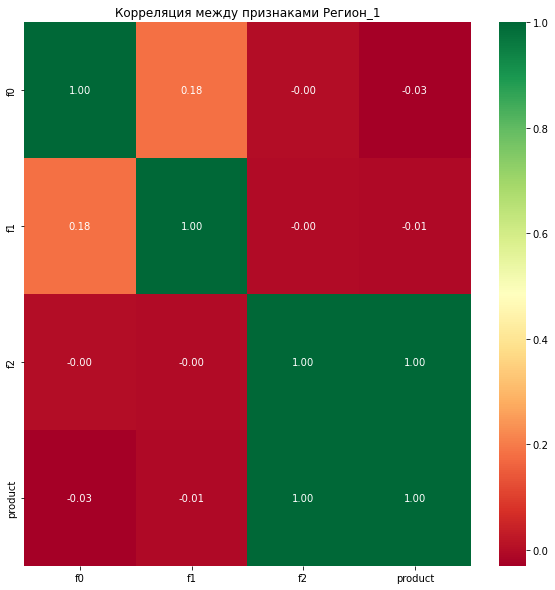

In [18]:
Corr_1=data_1.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Corr_1, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками Регион_1')

In [19]:
print()
print("\nКорреляция данных Регион 2")
display(data_2.corr())



Корреляция данных Регион 2


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Text(0.5, 1.0, 'Корреляция между признаками Регион_2')

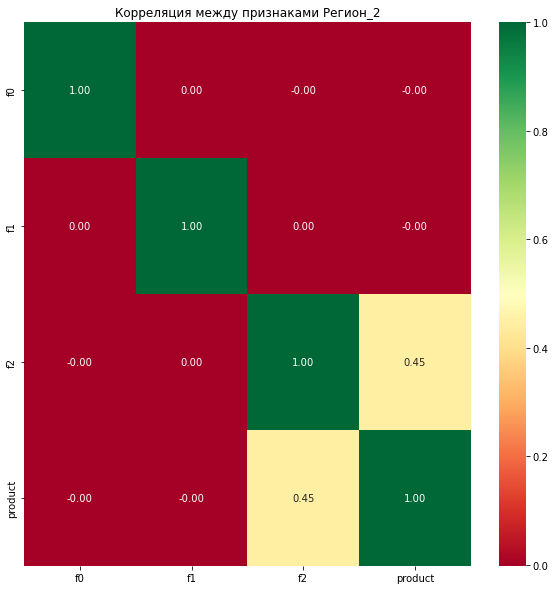

In [20]:
Corr_2=data_2.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Corr_2, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками Регион_2')

Корреляция между признаками показывает, что:
- в Регионе_0 есть средняя отрицательная корреляция между признаками f0 и f1, и средняя положительная корреляция между целевым признаком и признаком f2. 
- в Регион_1  между целевым признаком и признаком f2 очень высокая корреляция. Это значит, что они полностью взаимосвязаны. 
- корреляция данных в Регион_2 похожа на корреляцию данных в Регион_0, за исключением отрицательной корреляции между признаками f0 и f1.

Разделим обучающий датафрейм каждого региона на features и target - целевой признак

In [21]:
target_0 = data_0['product']
features_0 = data_0.drop('product', axis=1)

In [22]:
target_1 = data_1['product']
features_1 = data_1.drop('product', axis=1)

In [23]:
target_2 = data_2['product']
features_2 = data_2.drop('product', axis=1)

Разобьем данные для каждого региона на две выборки: обучающую и валидационную в отношении 3:1.

In [24]:
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)
print('Размер обучающей выборки Регион_0:',features_0_train.shape[0])
print('Размер валидационной выборки Регион_0:',features_0_valid.shape[0])
print('Общий размер исходного датасета Регион_0: {} (сумма выборок: {})'.
      format(data_0.shape[0], features_0_train.shape[0]+features_0_valid.shape[0]))

Размер обучающей выборки Регион_0: 75000
Размер валидационной выборки Регион_0: 25000
Общий размер исходного датасета Регион_0: 100000 (сумма выборок: 100000)


In [25]:
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)
print('Размер обучающей выборки Регион_1:',features_1_train.shape[0])
print('Размер валидационной выборки Регион_1:',features_1_valid.shape[0])
print('Общий размер исходного датасета Регион_1: {} (сумма выборок: {})'.
      format(data_1.shape[0], features_1_train.shape[0]+features_1_valid.shape[0]))

Размер обучающей выборки Регион_1: 75000
Размер валидационной выборки Регион_1: 25000
Общий размер исходного датасета Регион_1: 100000 (сумма выборок: 100000)


In [26]:
features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)
print('Размер обучающей выборки Регион_2:',features_2_train.shape[0])
print('Размер валидационной выборки Регион_2:',features_2_valid.shape[0])
print('Общий размер исходного датасета Регион_2: {} (сумма выборок: {})'.
      format(data_2.shape[0], features_2_train.shape[0]+features_2_valid.shape[0]))

Размер обучающей выборки Регион_2: 75000
Размер валидационной выборки Регион_2: 25000
Общий размер исходного датасета Регион_2: 100000 (сумма выборок: 100000)


#### Выводы

Данные успешно загружены и проверены на соответствие описанию.

Даннные из файлов в трёх регионах имеют по 100 тыс объектов, по 5 признаков. Все объекты уникальны, дубликатов и пропусков нет.

Удалили столбец id, так как для обучения моделей он нам не понадобится.

В данных Регион_1 между целевым признаком и признаком f2 имеется очень высокая корреляция, а в данных Регион_0 и Регион_2 имеется средняя положительная корреляция между целевым признаком и признакоми f2. В данных Регионе_0 есть средняя отрицательная корреляция между признаками f0 и признаком f1,

Разделили обучающий датафрейм каждого региона на features и target - целевой признак

Данные для каждого региона разбили на две выборки: обучающую и валидационную в отношении 3:1.

## 2. Обучение и проверка модели

Для обучения используем модель линейной регрессии 

Но сначала выполним масштабирование данных

In [27]:
numeric = ['f0', 'f0', 'f0']

In [28]:
scaler = StandardScaler()
scaler.fit(features_0_train[numeric])
features_0_train[numeric] = scaler.transform(features_0_train[numeric])
features_0_valid[numeric] = scaler.transform(features_0_valid[numeric])

In [29]:
scaler = StandardScaler()
scaler.fit(features_0_train[numeric])
features_1_train[numeric] = scaler.transform(features_1_train[numeric])
features_1_valid[numeric] = scaler.transform(features_1_valid[numeric])

In [30]:
scaler = StandardScaler()
scaler.fit(features_0_train[numeric])
features_2_train[numeric] = scaler.transform(features_2_train[numeric])
features_2_valid[numeric] = scaler.transform(features_2_valid[numeric])

Создаем модели линейной регрессии для каждого региона

In [31]:
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()

Обучаем модели линейной регрессии для каждого региона

In [32]:
model_0.fit(features_0_train, target_0_train)
model_1.fit(features_1_train, target_1_train)
model_2.fit(features_2_train, target_2_train)

LinearRegression()

Делаем предсказания для каждого региона на валидационной выборке. 

Сохраняем предсказания и правильные ответы на валидационной выборке.

In [33]:
predicted_0_valid = model_0.predict(features_0_valid)
predicted_1_valid = model_1.predict(features_1_valid)
predicted_2_valid = model_2.predict(features_2_valid)

Выведем на экран средний запас предсказанного сырья и метрику машинного обычения RMSE (Root Mean Square Error - квадратный корень среднеквадратичной ошибки) для каждого региона

In [34]:
rmse_0 = mean_squared_error(target_0_valid, predicted_0_valid) ** 0.5
mean_product_0 = predicted_0_valid.mean().round(2)
print("Linear Regression Регион_0")
print("Средний запас предсказанного сырья:", mean_product_0, "тыс. баррелей")
print("RMSE =", rmse_0.round(4))
print()
rmse_1 = mean_squared_error(target_1_valid, predicted_1_valid) ** 0.5
mean_product_1 = predicted_1_valid.mean().round(2)
print("Linear Regression Регион_1")
print("Средний запас предсказанного сырья:", mean_product_1, "тыс. баррелей")
print("RMSE =", rmse_1.round(4))
print()
rmse_2 = mean_squared_error(target_2_valid, predicted_2_valid) ** 0.5
mean_product_2 = predicted_2_valid.mean().round(2)
print("Linear Regression Регион_2")
print("Средний запас предсказанного сырья:", mean_product_2, "тыс. баррелей")
print("RMSE =", rmse_2.round(4))

Linear Regression Регион_0
Средний запас предсказанного сырья: 92.59 тыс. баррелей
RMSE = 37.5794

Linear Regression Регион_1
Средний запас предсказанного сырья: 68.73 тыс. баррелей
RMSE = 0.8931

Linear Regression Регион_2
Средний запас предсказанного сырья: 94.97 тыс. баррелей
RMSE = 40.0297


Для наглядности выведем информацию графически

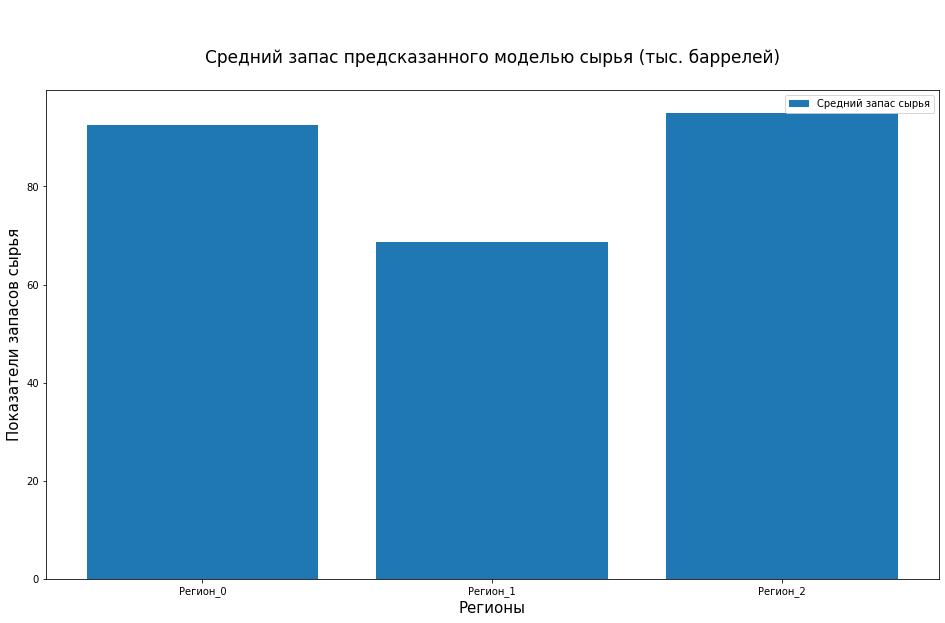

In [35]:
from IPython.core.pylabtools import figsize
mean_product = [mean_product_0, mean_product_1, mean_product_2]
regions = ["Регион_0", "Регион_1","Регион_2"]
columns = ["region", "mean_product"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16, 9))

ax.bar(x = regions, height = mean_product, label = "Средний запас сырья")
ax.set_title("\n\nСредний запас предсказанного моделью сырья (тыс. баррелей)\n", fontsize = 17)
ax.legend()
plt.xlabel("Регионы", fontsize = 15)
plt.ylabel("Показатели запасов сырья", fontsize = 15)
plt.show()

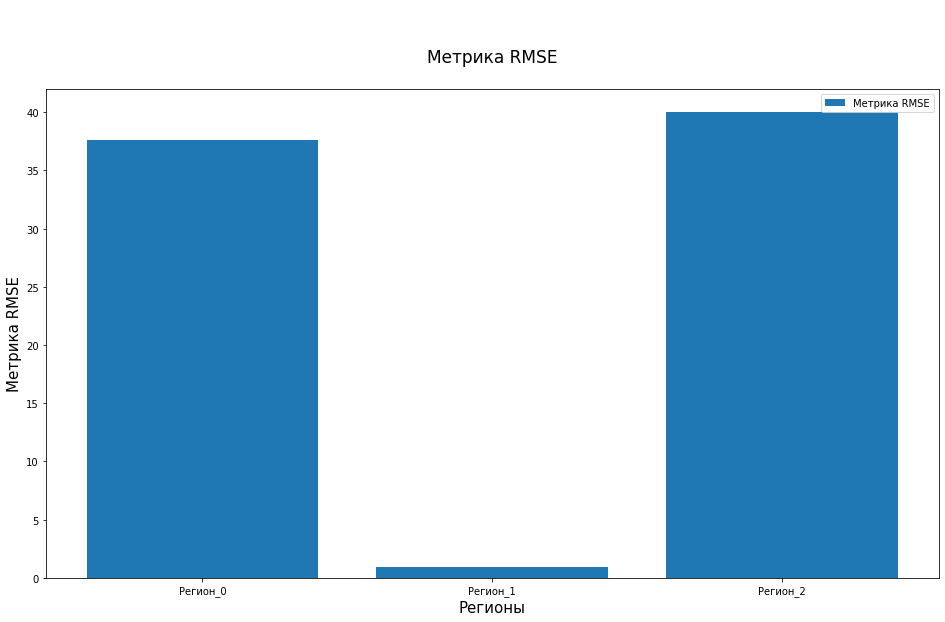

In [36]:
from IPython.core.pylabtools import figsize
rmse = [rmse_0, rmse_1, rmse_2]
regions = ["Регион_0", "Регион_1","Регион_2"]
columns = ["region", "rmse"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16, 9))

ax.bar(x = regions, height = rmse, label = "Метрика RMSE")
ax.set_title("\n\nМетрика RMSE\n", fontsize = 17)
ax.legend()
plt.xlabel("Регионы", fontsize = 15)
plt.ylabel("Метрика RMSE", fontsize = 15)
plt.show()

#### Выводы

Для предсказания объёмов добычи нефти в трёх регионах построили модель машинного обучения LinearRegression - линейная регрессия. 

Для каждого региона мы рассчитали средний запас предсказанного сырья и определили метрику RMSE (Root Mean Square Error - квадратный корень среднеквадратичной ошибки). Метрики RMSE трёх регионов были сохранены в уникальные переменные.

- Регион_2 имеет наибольший предсказанный запас сырья 94.97 тыс. баррелей, с RMSE - 40.02.
- Регион_0 имеет предсказанный запас сырья 92.59 тыс. баррелей, с RMSE 37.57.
- Регион_1 имеет наименьший предсказанный запас сырья 68.73 тыс. баррелей, но и с наименьшим RMSE 0.89.

Чем меньше показатель RMSE, тем точнее прогноз модели машинного обучения.

Прогноз модели LinearRegression в Регион_0 и Регион_2 имеют высокий  RMSE (37.57 и 40.02 соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии. 

Прогноз модели LinearRegression в Регион_1 имеет наименьшую метрику RMSE. Это говорит о точности предсказаний и качестве построенной модели.

## 3. Подготовка к расчёту прибыли

Сохраним в отдельных переменных ключевые значения для расчётов

In [37]:
all_points = 500 # Общее количество скважин в регионе для исследования
top_points = 200 # Количество скважин в регионе для разработки
income_per_one = 450e3 # Доход с одной единицы сырья (1 тысяча баррелей нефти)
budget = 10e9 # Бюджет на разработку скважин в регионе
min_product_points = budget / top_points / income_per_one # Минимальный запас сырья в скважине для безубыточности

print(f'Бюджет на разработку скважин в регионе (руб.): {budget}')
print(f'Количество скважин в регионе для исследования: {all_points}')
print(f'Количество скважин в регионе для разработки: {top_points}')
print(f'Доход с одной тысячи баррелей (руб.): {income_per_one}')
print()
print(f'Минимальный запас сырья в скважине для безубыточности (тыс. баррелей): {min_product_points:.3f}')

Бюджет на разработку скважин в регионе (руб.): 10000000000.0
Количество скважин в регионе для исследования: 500
Количество скважин в регионе для разработки: 200
Доход с одной тысячи баррелей (руб.): 450000.0

Минимальный запас сырья в скважине для безубыточности (тыс. баррелей): 111.111


Сравним полученный минимальный запас сырья в скважине для безубыточности со средним запасом в каждом регионе.

In [38]:
def volume_of_materials(data):
    difference =  data['product'].mean() - min_product_points 
    if difference >= 0:
        print('Досаточный объём сырья для безубыточной разработки новой скважины. Запас равен:', round(difference,2), 'тыс.баррелей')
    else:
        print('Недостаточный объём сырья для безубыточной разработки новой скважины. Не хватает:', round(difference,2), 'тыс.баррелей') 
        

In [39]:
volume_of_materials(data_0)

Недостаточный объём сырья для безубыточной разработки новой скважины. Не хватает: -18.61 тыс.баррелей


In [40]:
volume_of_materials(data_1)

Недостаточный объём сырья для безубыточной разработки новой скважины. Не хватает: -42.29 тыс.баррелей


In [41]:
volume_of_materials(data_2)

Недостаточный объём сырья для безубыточной разработки новой скважины. Не хватает: -16.11 тыс.баррелей


#### Выводы

Таким образом, достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111 тыс. баррелей. 

Данный показатель рассчитан при условии выбора 200 лучших скважин из 500 в выборке.

Данное значение достаточного объёма сырья для безубыточной разработки новой скважины превышает средние значения запасов сырья скважин по всем регионам.

## 4. Расчёт прибыли и рисков

Создадим функцию расчёта прибыли, которая будет принимать на вход предсказания и правильные ответы и рассчитывать необходимое значение прибыли.

In [42]:
predictions_0 = pd.Series(model_0.predict(features_0_valid), index = features_0_valid.index)
predictions_1 = pd.Series(model_1.predict(features_1_valid), index = features_1_valid.index)
predictions_2 = pd.Series(model_2.predict(features_2_valid), index = features_2_valid.index)

In [43]:
all_points = 500 # Общее количество скважин в регионе для исследования
top_points = 200 # Количество скважин в регионе для разработки
income_per_one = 450e3 # Доход с одной единицы сырья (1 тысяча баррелей нефти)
budget = 10e9 # Бюджет на разработку скважин в регионе
min_product_points = budget / top_points / income_per_one # Минимальный запас сырья в скважине для безубыточности


In [44]:
def profit(predictions, target):
    predictions = predictions.sort_values(ascending = False)
    top_200 = target.loc[predictions.index][:top_points]
    product = top_200.sum() # суммарное количество сырья с топ - 200 точек
    income = product * income_per_one
    profit = income - budget
    return profit

In [45]:
profit_0 = profit(predictions_0, target_0_valid)
print(f"Прибыль в Регион_0: {(profit_0/1_000_000_000).round(2)} млрд. руб.")
profit_1 = profit(predictions_1, target_1_valid)
print(f"Прибыль в Регион_1: {(profit_1/1_000_000_000).round(2)} млрд. руб.")
profit_2 = profit(predictions_2, target_2_valid)
print(f"Прибыль в Регион_2: {(profit_2/1_000_000_000).round(2)} млрд. руб." )

Прибыль в Регион_0: 3.32 млрд. руб.
Прибыль в Регион_1: 2.42 млрд. руб.
Прибыль в Регион_2: 2.71 млрд. руб.


Наиболее прибыльным является Регион 0: при разработке скважин в этом регионе компания получит прибыль в размере 3.32 млрд. руб.

Наименее прибыльным регионом является Регион_1: при разработке скважин в этом регионе компания получит прибыль в размере 2.42 млрд. руб.

Данные величины прибыли получены с допущением, что из всех 25 000 скважин, которые есть в регионе, мы разведываем 200 с наибольшими запасами нефти.

На практике такое будет случаться не всегда, поэтому применим технику Bootstrap и узнаем более вероятное значение прибыли при разработке месторождений в том или ином регионе, а также вероятность получения прибыли в случае проведения работ в регионе.

Для этого построим распределение прибыли, используя бутстрапирование с 1000 выборок: из набора данных с предсказаниями объёма добычи нефти для каждого региона случайным обазом 1000 раз отберём 200 скважин и посчитаем прибыль, которую получит компания при разработке этих скважин.

Затем посчитаем среднее значение прибыли из 1000 значений прибыли для бутстрапированных выборок и определим 95% - интервал для этого среднего значения.

Определим вероятность получения убытков при работе в исследуемом регионе (риск убытков).

In [46]:
def functionBootstrap(predictions, target):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_subsample = target.sample(n = 500, replace = True, random_state = state)
        pred_subsample = predictions.loc[target_subsample.index]    
        values.append(profit(pred_subsample, target_subsample))

    values = pd.Series(values)

    lower = round(values.quantile(0.05), 3)
    upper = round(values.quantile(0.95), 3)

    mean = round(values.mean(), 3)

    risk_of_loss = (values < 0).mean()
    
    print(f"Средняя прибыль: {mean} млрд. руб.")
    print(f"Доверительный интервал прибыли: от {lower} млрд. руб., до {upper} млрд. руб.")
    print('Риск убытков:','{:.2f}'.format(risk_of_loss*100), '%')
    #print()
    #plt.hist(values, bins = 50, color = "c")
    #plt.suptitle("Распределение прибыли из бутстрапированных выборок имеет сделующий вид", fontsize = 15)
    #plt.xlabel("Прибыль, млрд. руб.")
    #plt.ylabel("Количество скважин")
    #plt.show()

In [47]:
print("Расчёт прибыли и рисков для Регион_0:")
functionBootstrap(predictions_0, target_0_valid)

Расчёт прибыли и рисков для Регион_0:
Средняя прибыль: 425938526.911 млрд. руб.
Доверительный интервал прибыли: от -31803114.346 млрд. руб., до 881341454.36 млрд. руб.
Риск убытков: 6.00 %


In [48]:
print("Расчёт прибыли и рисков для Регион_1:")
functionBootstrap(predictions_1, target_1_valid)

Расчёт прибыли и рисков для Регион_1:
Средняя прибыль: 515222773.443 млрд. руб.
Доверительный интервал прибыли: от 150785740.641 млрд. руб., до 861521464.101 млрд. руб.
Риск убытков: 1.00 %


In [49]:
print("Расчёт прибыли и рисков для Регион_2:")
functionBootstrap(predictions_2, target_2_valid)

Расчёт прибыли и рисков для Регион_2:
Средняя прибыль: 435008362.783 млрд. руб.
Доверительный интервал прибыли: от -43448491.323 млрд. руб., до 897954688.902 млрд. руб.
Риск убытков: 6.40 %


#### Выводы

Регион_0:
- средняя прибыль 0.426 млрд. рублей
- 5 % - квантиль -0.032 млрд. рублей
- 95 % - квантиль 0.881 млрд. рублей
- риск убытков 6.00 %

Регион_1:
- средняя прибыль 0.515 млрд. рублей
- 5 % - квантиль 0.151 млрд. рублей
- 95 % - квантиль 0.862 млрд. рублей
- риск убытков 1.00 %

Регион_2:
- средняя прибыль 0.435 млрд. рублей
- 5 % - квантиль -0.129 млрд. рублей
- 95 % - квантиль 0.97 млрд. рублей
- риск убытков 6.40 %

Регион_0 и Регион_2 имеют риски получения убытков 6.00% и 6.40% со средней прибылью 0.426 и 0.435 млрд. рублей соответственно. 

Регион_1, со средней прибылью 0.515 млрд. рублей, почти не подвержен риску убытков - 1.00 %.

На основании проведенных исследований для разработки скважин предлагаем Регион_1. В этой местности разработка имеет минимальные риски убытков и предполагает наибольшую прибыль от добычи нефти.

### Общий вывод

Проект выполнен для добывающей компании «ГлавРосГосНефть» с целью определения района для разработки новых скважин.

В процессе исследований мы использовали пробы нефти из трёх регионов. В каждом регионе по 10 тысяч месторождений. Измерили качество нефти и объём запасов.

##### При загрузке и подготовке данных:
-  выяснили, что в наборе данных представлены пробы нефти в трёх регионах. По составу наборы данных идентичны друг другу: все три набора данных содержат id скважины, 3 параметра, описывающие некоторые характеристики скважин, а также объём запасов нефти в скважине (в тыс. баррелей).
- определили, что каждый набор данных сожержит по 100 тыс. наблюдений и 5 признаков.
- определили, что данные не содержат аномалий и пропущенных значений. Дублируется незначительное количество id. Вероятно произошла ошибка при записи id. Остальные данные с одинаковыми id не дублируются, поэтому не удалял строки с дублирующимися id. Дополнительная предварительная обработка не требуется.
- удалили столбец id из каждого набора данных, так как для обучения моделей он нам не понадобится.
- выяснили, что в данных Регион_1 между целевым признаком и признаком f2 имеется очень высокая корреляция, а в данных Регион_0 и Регион_2 имеется средняя положительная корреляция между целевым признаком и признакоми f2. В данных Регионе_0 есть средняя отрицательная корреляция между признаками f0 и признаком f1,
- разделили обучающий датафрейм каждого региона на features и target - целевой признак
- данные для каждого региона разбили на две выборки: обучающую и валидационную в отношении 3:1.

##### Обучение и проверка модели:
- для предсказания объёмов добычи нефти в трёх регионах построили модель машинного обучения LinearRegression - линейная регрессия.
- для каждого региона мы рассчитали средний запас предсказанного сырья и определили метрику RMSE (Root Mean Square Error - квадратный корень среднеквадратичной ошибки). Метрики RMSE трёх регионов были сохранены в уникальные переменные.
  - Регион_2 имеет наибольший предсказанный запас сырья 94.97 тыс. баррелей, с RMSE - 40.02.
  - Регион_0 имеет предсказанный запас сырья 92.59 тыс. баррелей, с RMSE 37.57.
  - Регион_1 имеет наименьший предсказанный запас сырья 68.73 тыс. баррелей, но и с наименьшим RMSE 0.89.

Чем меньше показатель RMSE, тем точнее прогноз модели машинного обучения.

- прогноз модели LinearRegression в Регион_0 и Регион_2 имеют высокий RMSE (37.57 и 40.02 соответственно). Это свидетельствует о неоднозначности показателя, неточности модели регрессии.
- прогноз модели LinearRegression в Регион_1 имеет наименьшую метрику RMSE. Это говорит о точности предсказаний и качестве построенной модели.

##### Подготовка к расчёту прибыли:
- сохранили в отдельных переменных ключевые значения для расчётов
- определили, что достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111 тыс. баррелей.
  Данный показатель рассчитан при условии выбора 200 лучших скважин из 500 в выборке.
  Данное значение достаточного объёма сырья для безубыточной разработки новой скважины превышает средние значения запасов сырья скважин по всем регионам.
  
##### Расчет прибыли и рисков 
- На данном этапе мы рассчитали возможную прибыль от разработки регионов и оценили риски проведения работ в этих регионах.

Регион_0:
- средняя прибыль 0.426 млрд. рублей
- 5 % - квантиль -0.032 млрд. рублей
- 95 % - квантиль 0.881 млрд. рублей
- риск убытков 6.00 %

Регион_1:
- средняя прибыль 0.515 млрд. рублей
- 5 % - квантиль 0.151 млрд. рублей
- 95 % - квантиль 0.862 млрд. рублей
- риск убытков 1.00 %

Регион_2:
- средняя прибыль 0.435 млрд. рублей
- 5 % - квантиль -0.129 млрд. рублей
- 95 % - квантиль 0.97 млрд. рублей
- риск убытков 6.40 %

Регион_0 и Регион_2 имеют риски получения убытков 6.00% и 6.40% со средней прибылью 0.426 и 0.435 млрд. рублей соответственно. 

Регион_1, со средней прибылью 0.515 млрд. рублей, почти не подвержен риску убытков - 1.00 %.

#### На основании проведенных исследований для разработки скважин предлагается Регион_1. В этой местности разработка имеет минимальные риски убытков и предполагает наибольшую прибыль от добычи нефти.